In [1]:
from Functions import *


In [2]:
''' loop parameters '''
NN = 100
E_err_list = np.linspace(-1, 1, NN)
duration = np.zeros(NN)
tilt = np.zeros(NN)
bw = np.zeros(NN)
throughput = np.zeros(NN)
cent_E = np.zeros(NN)

if_loop = 1			# to loop or not to loop

In [3]:
''' Beam parameters '''
N = 2048			# number of sampling points
E0 = 12665			# photon energy [eV]
tau = 100			# pulse duration [fs]
window = 20000		# total simulation time window [fs]

''' OE parameters '''
#hkl = [6,6,0]
hkl = [4,4,0]
#hkl = [3,3,3]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 630
}


In [4]:
''' IO '''
path = '../{} eV/'.format(E0)
make_dir(path)

fig_path = path+'/E_scan/'
make_dir(fig_path)

hkl_ = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'E_tolerance_{}_{}keV'.format(
	hkl_, round(beam_params['photonEnergy']/1000.,4))

blockPrint()


path exists
make path


In [5]:
''' Define beamline '''
crystal_temp = optics.Crystal('crystal', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
							  alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

alphaAsym = crystal_temp.alpha - np.deg2rad(5)      # calculate miscut angle (5 degree grazing incidence)
if alphaAsym <= 0:
	print('\n***\n***\n*** Bragg angle smaller than grazing angle')

f1 = 9.737064715719063
f2 = 10.

devices = define_devices(f1,f2,slit_width = 2000e-6, hkl = hkl,
                         alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)

In [6]:
''' propagate '''
blockPrint()
mono_beamline = beamline.Beamline(devices)

tstart = time.time()
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)

pulse.propagate(beamline=mono_beamline, screen_names=['im0','im2'])
tfin = time.time()


C:\Users\nanw0\Anaconda3\envs\lcls\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [7]:
%%capture capt
''' loop '''
if if_loop == 1:
    for i, E_err in enumerate(E_err_list):
        E = E0 + E_err
        # pulse duration and tilt
        devices = define_devices(f1,f2,slit_width = 2000e-6, hkl = hkl,
                             alphaAsym = alphaAsym, E0=E, f0 = 290., d23=7.)
        lens_energyError(devices, E0)
        mono_beamline = beamline.Beamline(devices)
        beam_params['photonEnergy'] = E
        pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
        pulse.propagate(beamline=mono_beamline, screen_names=['im2'])
        centroid, duration[i] = pulse.pulse_duration('im2')
        tilt[i] = pulse.pulsefront_tilt('im2')

        # else (closed slit)
        devices = define_devices(f1,f2,slit_width = 7e-6, hkl = hkl,
                             alphaAsym = alphaAsym, E0=E, f0 = 290., d23=7.)
        lens_energyError(devices, E0)
        mono_beamline = beamline.Beamline(devices)
        beam_params['photonEnergy'] = E
        pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
        pulse.propagate(beamline=mono_beamline, screen_names=['im0','im2'])
        bw[i] = pulse.pulse_bandwidth('im2')
        throughput[i] = pulse.throughput('im0','im2')
        cent_E[i] = pulse.central_energy('im2')

    try:
        if_old = 0
        with h5py.File(fig_path+fname+'.h5','a') as f:
            f.create_dataset('E_err', data=E_err_list)
            f.create_dataset('duration', data=duration)
            f.create_dataset('tilt', data=tilt)
            f.create_dataset('bandwidth', data=bw)
            f.create_dataset('throughput', data=throughput)
            f.create_dataset('central_energy', data=cent_E)
    except:
        if_old = 1
        print('overwriting old data')
        os.remove(fig_path+fname+'.h5')
        with h5py.File(fig_path+fname+'.h5','a') as f:
            f.create_dataset('E_err', data=E_err_list)
            f.create_dataset('duration', data=duration)
            f.create_dataset('tilt', data=tilt)
            f.create_dataset('bandwidth', data=bw)
            f.create_dataset('throughput', data=throughput)
            f.create_dataset('central_energy', data=cent_E)


In [8]:
if if_old == 1:
    print('overwritten')
else:
    print('new file generated')

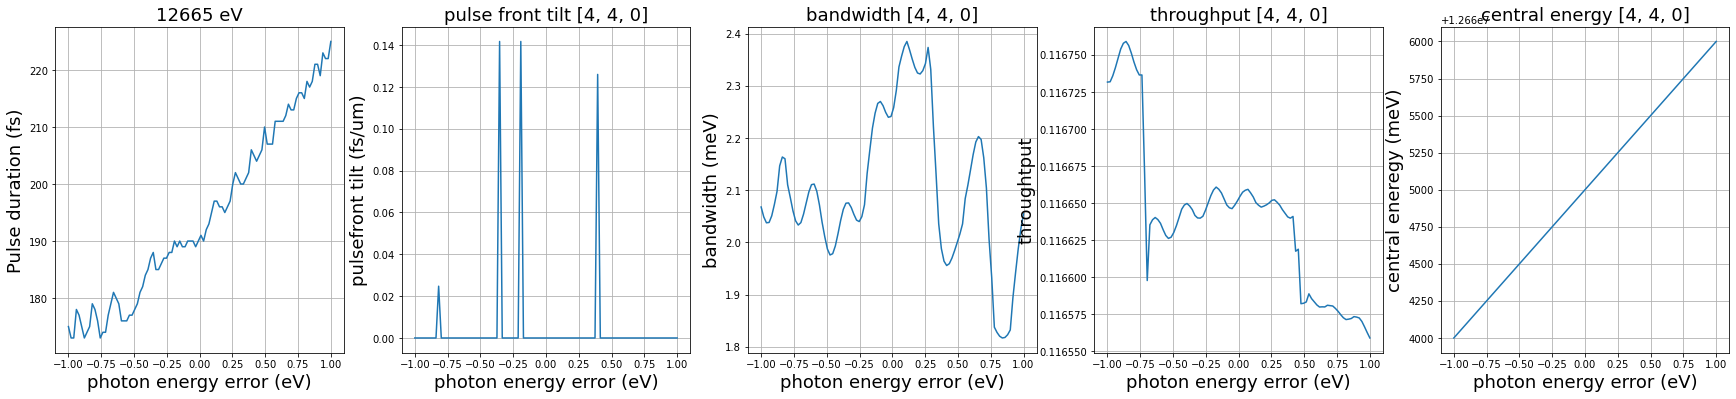

In [9]:
''' plot '''
with h5py.File(fig_path+fname+'.h5', 'r') as f:
    E_err_list = f['E_err'][:]
    duration = f['duration'][:]
    tilt = f['tilt'][:]
    bw = f['bandwidth'][:]
    throughput = f['throughput'][:]
    cent_E = f['central_energy'][:]

# plots
xx = E_err_list
xlabel = 'photon energy error (eV)'

# pulse duration
plt.figure(figsize=(30,6))
plt.subplot(1,5,1)
plt.plot(xx, np.abs(duration))
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('Pulse duration (fs)',fontsize=(18))
#plt.ylim([0,10000])

plt.grid()
plt.title('{} eV'.format(E0),fontsize=(18))

# pulsefront tilt
plt.subplot(1,5,2)
plt.plot(xx, tilt)
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('pulsefront tilt (fs/um)',fontsize=(18))

plt.grid()
plt.title('pulse front tilt {}'.format(hkl),fontsize=(18))
# bandwidth
plt.subplot(1,5,3)
plt.plot(xx, 1e3*bw)
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('bandwidth (meV)',fontsize=(18))

plt.grid()
plt.title('bandwidth {}'.format(hkl),fontsize=(18))
#plt.ylim([0,3])

# throughput
plt.subplot(1,5,4)
plt.plot(xx, throughput)
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('throughtput',fontsize=(18))

plt.grid()
plt.title('throughput {}'.format(hkl),fontsize=(18))
#plt.ylim([.02,.06])

# central energy
plt.subplot(1,5,5)
plt.plot(xx, 1e3*cent_E)
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('central eneregy (meV)',fontsize=(18))

plt.grid()
plt.title('central energy {}'.format(hkl),fontsize=(18))

plt.savefig(fig_path+fname+'.png')

In [10]:
import winsound
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)